In [6]:
# import relevant package
import numpy as np
import cv2
import matplotlib.pyplot as plt
# this package is to read several files in a folder
import glob

# Color Space and Channel

Objects in images have distinct colors and luminosities. In RGB the hue and the luminosity are expressed as a linear combination of the R,G,B channels, whereas they correspond to single channels of the HSV image (the Hue and the Value channels). The Saturation channel controls how colorful the object is. Low saturation -> object looks very grey.

scikit-image has an interesting [article](https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_rgb_to_hsv.html) about this. Please take a look if you are interested.
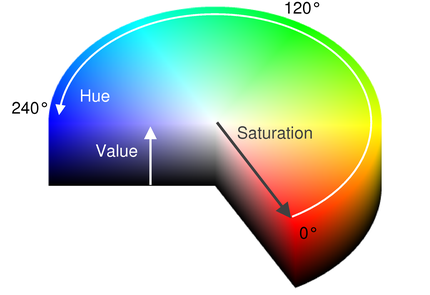

HSV is very useful when we are more interested in a certain color but not how bright or colorful it is.

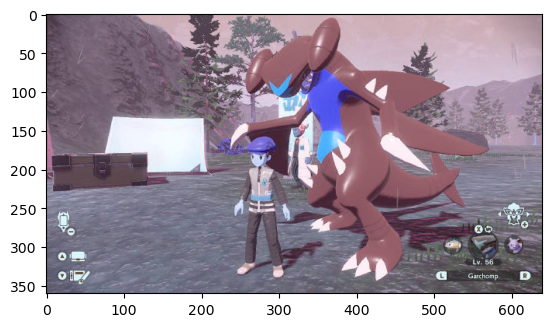

In [7]:
garchomp = cv2.imread('garchomp.jpg')
plt.imshow(garchomp)

Set a range of blue we want, and we can filter out the almost all the blue part of this Pokemon.

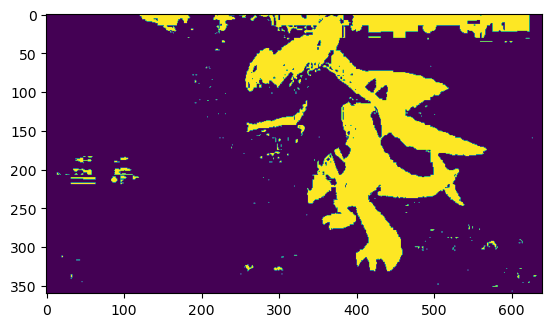

In [8]:
hsv = cv2.cvtColor(garchomp, cv2.COLOR_BGR2HSV)

# define range of blue color in HSV
lower_blue = np.array([110,35,35])
upper_blue = np.array([130,255,255])

# Threshold the HSV image to get only blueish colors
mask = cv2.inRange(hsv, lower_blue, upper_blue)

plt.imshow(mask)

We can do something even more interesting. Here we have a picture that seems to have only blue, green and red. Reading it using OpenCV and visualize it.

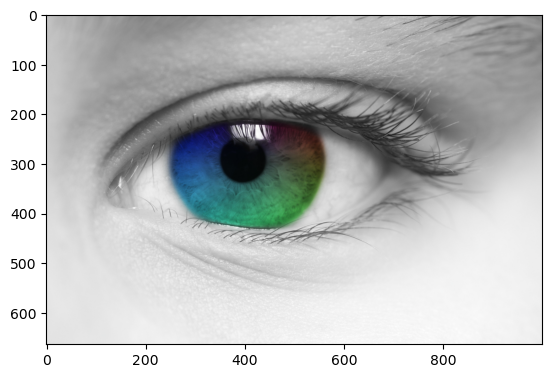

In [9]:
img = cv2.imread('for_watson.png')
plt.imshow(img)

Convert it to HSV color space using OpenCV, and we seperate each each channel

In [10]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

h = img_hsv[:,:,0]
s = img_hsv[:,:,1]
v = img_hsv[:,:,2]

And we visualize each channel. We use grayscale because we just want to see if there are some pixels that are different from its neighbors.

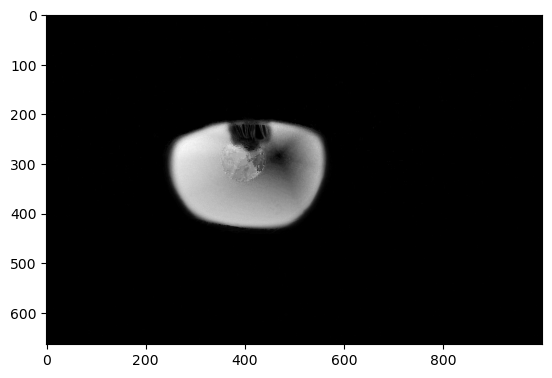

In [11]:
plt.imshow(s, cmap='gray')

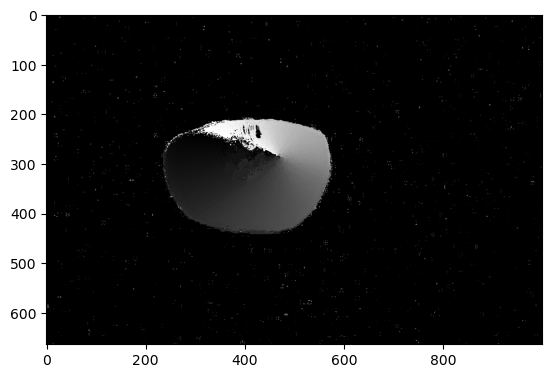

In [12]:
plt.imshow(h, cmap='gray')

# Camera Calibration

This section will introduce you to OpenCV's camera calibration process. This method, usually called Zhang's method, is published by Zhengyou Zhang from Microsfot Research in a paper titled "A flexible new technique for camera calibration". [Link to the original paper here](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr98-71.pdf).

We will be using a chessboard image to do camera calibration.

The notebook is adapted from OpenCV's [Tutorial on Camera Calibration](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html).

First step, we need an "ideal model" of point locations on a chessboard. We will use a 7*6 chessboard, so the layout of points follow that. 

I will not dive into the details of these numpy code that generate such (x, y, z) coordinates. You are welcome to reach out to me during office hour to let me walk you through these Python tricks if interested. But generally they are not terribly important and there are many alternative ways to achieve the same thing.

It's worth noting that all the points are in 3-dimensional space, but since they should all reside on a checkerboard, the z coordinates are all 0.

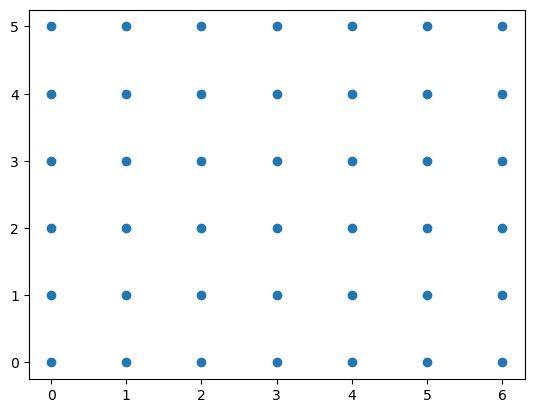

In [13]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

plt.scatter(objp[:, 0], objp[:, 1]);

We now use the `glob` package to collect all the photos we took of this chessboard for calibration. 

Here, * indicates a wildcard character. Basically it means that glob will grab any file that starts with "left", followed by some characters, and ends with ".jpg".

In [14]:
images = glob.glob('left*.jpg')

We create some variables that will remain the same or will be modified inplace throughout the entire algorithm so we don't recreate them every time we process one photo.

In [15]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# termination criteria for cornerSubPix. 
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

The next code block will find corners(intersections) on the photos of checkerboard.

1. First, use OpenCV's IO to read one image at a time based on files grabbed by glob and convert it to grey scale.
2. Feed the image to `cv2.findChessboardCorners`. We specify that the chessboard in use is 7*6.
3. If `cv2.findChessboardCorners` does find corners, we use `cv2.cornerSubPix` to further improve the accuracy of such corners. Here we make use of the `criteria` as the termination criteria.
4. We append the coordinates of "ideal points" to `objpoints`, and the corner coordinates we just find to `imgpoints`, so we have correspondency for every photo of the checkerboard.
5. Visualize the corners we found on the photo using `cv2.drawChessboardCorners`.
6. Repeat this process for all the photos we've taken, which is 14 times in our case.

In [16]:
for fname in images:
    img = cv2.imread(fname)
    
    # Resize to make sure the image does not contain too much pixels for Opencv to find patterns
    img = cv2.resize(img, (640,480))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners, we use 7*6 grid
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        # cv2.cornerSubPix() increases the accuracy of the corner coordinates
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
    

        img = cv2.drawChessboardCorners(img, (7,6), corners2,ret)
        # replace the colab_imshow with the commented lines if on a local Jupyter environment
        cv2.imshow('img',img)
        cv2.waitKey(500)
# cv2.destroyAllWindows()

        # ! Actual checkerboard is 8*7 but 7*6 is also fine because it is smaller than the checkerboard
        

: 

Now with correspondency, we can pass all the coordinates and the shape of the image to `cv2.calibrateCamera`. The two `None` here are not relevant in our setup, but you are welcome to take a look at `cv2.calibrateCamera` documentation to figure out why they are here.

In [32]:
# cv2.calibrateCamera() returns the camera matrix, distortion coefficients, rotation vectors, and translation vectors

print(objpoints)
print(imgpoints)
print(gray)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

[array([[0., 0., 0.],
       [1., 0., 0.],
       [2., 0., 0.],
       [3., 0., 0.],
       [4., 0., 0.],
       [5., 0., 0.],
       [6., 0., 0.],
       [0., 1., 0.],
       [1., 1., 0.],
       [2., 1., 0.],
       [3., 1., 0.],
       [4., 1., 0.],
       [5., 1., 0.],
       [6., 1., 0.],
       [0., 2., 0.],
       [1., 2., 0.],
       [2., 2., 0.],
       [3., 2., 0.],
       [4., 2., 0.],
       [5., 2., 0.],
       [6., 2., 0.],
       [0., 3., 0.],
       [1., 3., 0.],
       [2., 3., 0.],
       [3., 3., 0.],
       [4., 3., 0.],
       [5., 3., 0.],
       [6., 3., 0.],
       [0., 4., 0.],
       [1., 4., 0.],
       [2., 4., 0.],
       [3., 4., 0.],
       [4., 4., 0.],
       [5., 4., 0.],
       [6., 4., 0.],
       [0., 5., 0.],
       [1., 5., 0.],
       [2., 5., 0.],
       [3., 5., 0.],
       [4., 5., 0.],
       [5., 5., 0.],
       [6., 5., 0.]], dtype=float32), array([[0., 0., 0.],
       [1., 0., 0.],
       [2., 0., 0.],
       [3., 0., 0.],
       [4., 0., 

: 

In [28]:
# print the values
print(mtx)
print(dist)
print(rvecs)
print(tvecs)

[[534.07088364   0.         341.53407554]
 [  0.         534.11914595 232.94565259]
 [  0.           0.           1.        ]]
[[-2.92971637e-01  1.07706962e-01  1.31038376e-03 -3.11018781e-05
   4.34798110e-02]]
(array([[-0.43239599],
       [ 0.25603401],
       [-3.08832021]]), array([[ 0.41531697],
       [ 0.65664497],
       [-1.3373494 ]]), array([[-0.2645143 ],
       [-0.39360849],
       [-2.74787379]]), array([[-0.37843358],
       [-0.18064237],
       [-3.11615996]]), array([[-0.45993978],
       [-0.3142018 ],
       [-1.76122223]]), array([[-0.29979221],
       [ 0.39216377],
       [-1.4348239 ]]), array([[-0.32034625],
       [ 0.1597993 ],
       [-1.24149595]]), array([[-0.45883216],
       [-0.08848877],
       [-1.33510786]]), array([[-0.35367631],
       [-0.24363035],
       [-1.56874295]]), array([[ 0.30697385],
       [ 0.5038552 ],
       [-1.82824733]]), array([[-0.17288944],
       [-0.46764681],
       [ 1.34745198]]), array([[-0.43239599],
       [ 0.25603

# Undistortion

As we can see from the following picture, sometimes in a distorted photo, lines that are supposed to be straight are appearing as curves. This is when we know that we will need to undistort the image first to do any further processing, as many algorithms introduced in this class assumes a perfectly linear camera model.

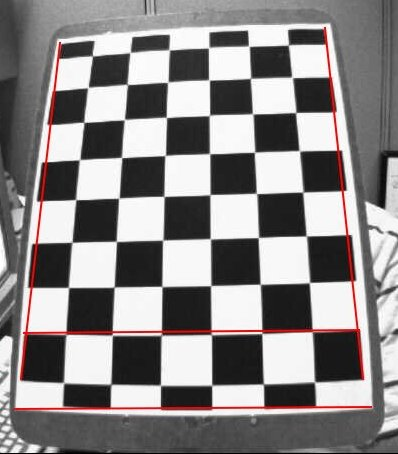

We utilize `cv2.getOptimalNewCameraMatrix` to refine the camera matrix.

If we pass 1 in as parameter, the undistorted image will most likely lose some pixels at the corners of the image. If we use 0, the undsitorted image will most likely have some dark pixels as fillers at the conrner (although not very obvious in this specific example).

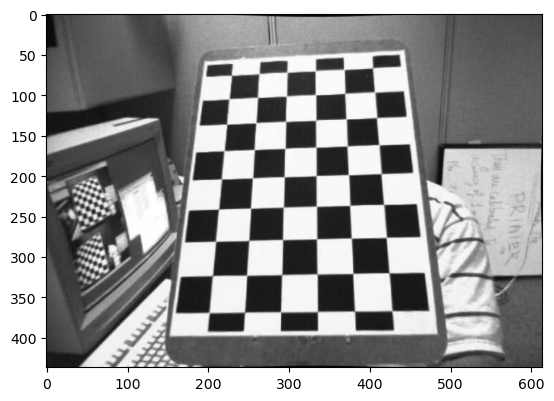

In [19]:
# Refine the camera matrix 
img = cv2.imread('left12.jpg')
h,  w = img.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
plt.imshow(dst)

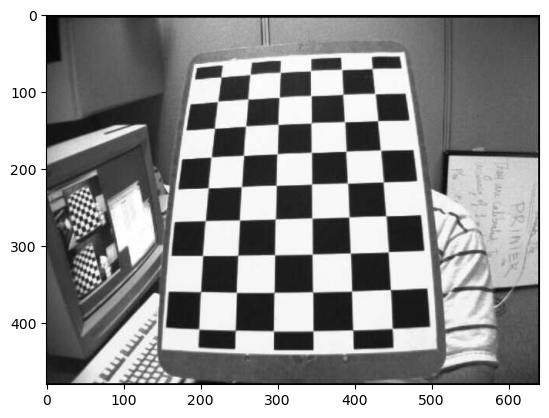

In [20]:
img = cv2.imread('left12.jpg')
plt.imshow(img)

In [21]:
# Find the re-projection error which measures how exact is the found parameters

mean_error = 0
for i in range(len(objpoints)):
    # transform the object point to image point
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    # calculate the absolute norm between our transformation and the corner finding algorithm
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error

print ("total error: ", mean_error/len(objpoints))

total error:  0.023686000375385676


# Camera calibration with your own camera!

If you are using Google Colab, you can take a few pics and upload them to Colab to do the calibration.

If you are using a local Jupyter environment, we provide a convenient snippet to capture pictures for you. 

It may takes some time to boot up OpenCV's video capture functionality, so be patient. 

After a windows pop up, hit Space to take a photo and hit Esc to exit.

In [22]:
# Capture chessboard images from camera

import cv2

cam = cv2.VideoCapture(0)

cv2.namedWindow("test")

img_counter = 0

while True:
    ret, frame = cam.read()
    if not ret:
        print("failed to grab frame")
        break
    cv2.imshow("test", frame)

    k = cv2.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        # SPACE pressed
        img_name = "opencv_frame_{}.jpg".format(img_counter)
        cv2.imwrite(img_name, frame)
        print("{} written!".format(img_name))
        img_counter += 1

cam.release()

cv2.destroyAllWindows()

opencv_frame_0.jpg written!
Escape hit, closing...


Here is the calibration process put into one single cell. Note that the dimension of "ideal points" are changed accordingly since we are using a different chessboard.

opps


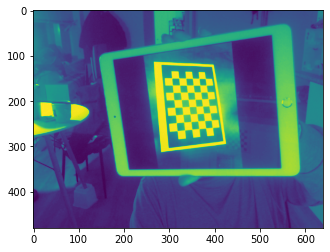

In [ ]:
# Similar code as above, except the dimension of chessboard is different now

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# use images captured by camera
images = glob.glob('opencv*.jpg')

for fname in images:
    img = cv2.imread(fname)
    
    # Resize to make sure the image does not contain too much pixels for Opencv to find patterns
    #img = cv2.resize(img, (640,480))
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)
    # Find the chess board corners, we use 7*6 grid
    ret, corners = cv2.findChessboardCorners(gray, (8,6),None)
    # If found, add object points, image points (after refining them)
    if ret == True:
      objpoints.append(objp)

      # cv2.cornerSubPix() increases the accuracy of the corner coordinates
      corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
      imgpoints.append(corners2)

      # Draw and display the corners
      img = cv2.drawChessboardCorners(img, (8,6), corners2,ret)
      #plt.imshow(img)
      cv2.imshow('img',img)
      cv2.waitKey(500)

cv2.destroyAllWindows()

In [ ]:
# cv2.calibrateCamera() returns the camera matrix, distortion coefficients, rotation vectors, and translation vectors
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [ ]:
# print the values
print(mtx)
print(dist)
print(rvecs)
print(tvecs)